NameError: name 'data_encoded' is not defined

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import us  # Import the us library

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.PCUtils.BackgroundKnowledgeOrientUtils import \
    orient_by_background_knowledge

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)
from sklearn.preprocessing import StandardScaler


In [4]:
depression = pd.read_csv("Student Depression Dataset.csv")
depression = depression.dropna()
depression = depression.replace({'Yes': 1, 'No': 0})

data_encoded = pd.get_dummies(depression, drop_first=True)
data_encoded = data_encoded[[
    'Academic Pressure',
    'Have you ever had suicidal thoughts ?',
    'Financial Stress',
    'City_Bhavna',
    'City_Kibara',
    'City_ME',
    'City_Mira',
    'City_Nalyan',
    'City_Nandini',
    'City_Saanvi',
    'City_Vaanya',
    'Profession_Civil Engineer',
    'Profession_Digital Marketer',
    'Profession_Doctor',
    'Profession_Manager',
    'Profession_Student',
    'Profession_Teacher',
    'Dietary Habits_Moderate',
    'Dietary Habits_Others',
    'Dietary Habits_Unhealthy',
    'Degree_Others',
    'Depression'
]]




In [5]:
# takes a long time to run
data_frame = data_encoded.sample(frac=1, random_state=42)

# Step 1: Convert DataFrame to NumPy array>
data_array = data_frame.to_numpy()

# Step 2: Apply the PC algorithm to discover the causal graph
alpha = 0.05  # Significance level
#pc_graph = pc(data_array, alpha, indep_test='kci')
pc_graph = pc(data_array, alpha)

# Step 3: Create labels for nodes based on DataFrame columns
node_labels = {i: col for i, col in enumerate(data_encoded.columns)}

# Step 4: Extract edges from the pc_graph and create a NetworkX directed graph
G = nx.DiGraph()
G.add_nodes_from(node_labels.keys())

# Add edges based on the adjacency matrix
for i in range(len(pc_graph.G.graph)):
    for j in range(len(pc_graph.G.graph)):
        if pc_graph.G.graph[i, j] != 0:  # Check for an edge
            if pc_graph.G.graph[j, i] == 1 and pc_graph.G.graph[i, j] == -1:
                # Case: i -> j
                G.add_edge(i, j, edge_type='directed')
            elif pc_graph.G.graph[j, i] == -1 and pc_graph.G.graph[i, j] == -1:
                # Case: i -- j (undirected)
                G.add_edge(i, j, edge_type='undirected')
            elif pc_graph.G.graph[j, i] == 1 and pc_graph.G.graph[i, j] == 1:
                # Case: i <-> j (bidirectional)
                G.add_edge(i, j, edge_type='bidirectional')

  0%|          | 0/22 [00:00<?, ?it/s]

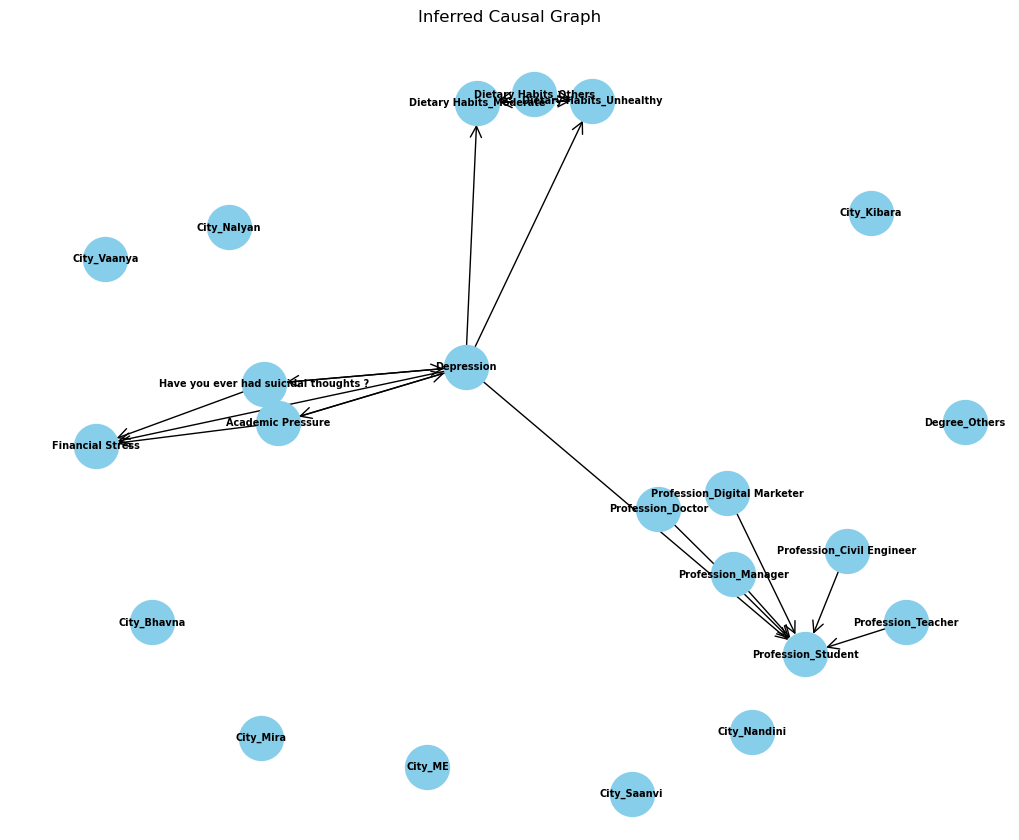

In [6]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Increase k for more space between nodes
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=1000, node_color="skyblue", font_size=7, font_weight="bold", arrowstyle="->", arrowsize=20)
plt.title("Inferred Causal Graph")
plt.show()

In [28]:
print(node_labels)

{0: 'Academic Pressure', 1: 'Have you ever had suicidal thoughts ?', 2: 'Financial Stress', 3: 'City_Bhavna', 4: 'City_Kibara', 5: 'City_ME', 6: 'City_Mira', 7: 'City_Nalyan', 8: 'City_Nandini', 9: 'City_Saanvi', 10: 'City_Vaanya', 11: 'Profession_Civil Engineer', 12: 'Profession_Digital Marketer', 13: 'Profession_Doctor', 14: 'Profession_Manager', 15: 'Profession_Student', 16: 'Profession_Teacher', 17: 'Dietary Habits_Moderate', 18: 'Dietary Habits_Others', 19: 'Dietary Habits_Unhealthy', 20: 'Degree_Others', 21: 'Depression'}


In [11]:
data_frame = data_encoded.sample(frac=1, random_state=42)
data_array = data_frame.to_numpy()
alpha = .05
pc_graph = pc(data_array, alpha)
node_labels = {i: col for i, col in enumerate(data_encoded.columns)}
G = nx.DiGraph()
G.add_nodes_from(node_labels.keys())
nodes = pc_graph.G.get_nodes()
nodes

  0%|          | 0/22 [00:00<?, ?it/s]

In [32]:
bk = BackgroundKnowledge()\
    .add_forbidden_by_node(nodes[17], nodes[19]) \
    .add_forbidden_by_node(nodes[17], nodes[18]) \
    .add_forbidden_by_node(nodes[18], nodes[17]) \
    .add_forbidden_by_node(nodes[18], nodes[19]) \
    .add_forbidden_by_node(nodes[19], nodes[17]) \
    .add_forbidden_by_node(nodes[19], nodes[18]) 

In [33]:
# takes a long time to run
data_frame = data_encoded.sample(frac=1, random_state=42)

# Step 1: Convert DataFrame to NumPy array>
data_array = data_frame.to_numpy()

# Step 2: Apply the PC algorithm to discover the causal graph
alpha = 0.05  # Significance level
#pc_graph = pc(data_array, alpha, indep_test='kci')
pc_graph = pc(data_array, alpha, BackgroundKnowledge=bk)

# Step 3: Create labels for nodes based on DataFrame columns
node_labels = {i: col for i, col in enumerate(data_encoded.columns)}

# Step 4: Extract edges from the pc_graph and create a NetworkX directed graph
G = nx.DiGraph()
G.add_nodes_from(node_labels.keys())

# Add edges based on the adjacency matrix
for i in range(len(pc_graph.G.graph)):
    for j in range(len(pc_graph.G.graph)):
        if pc_graph.G.graph[i, j] != 0:  # Check for an edge
            if pc_graph.G.graph[j, i] == 1 and pc_graph.G.graph[i, j] == -1:
                # Case: i -> j
                G.add_edge(i, j, edge_type='directed')
            elif pc_graph.G.graph[j, i] == -1 and pc_graph.G.graph[i, j] == -1:
                # Case: i -- j (undirected)
                G.add_edge(i, j, edge_type='undirected')
            elif pc_graph.G.graph[j, i] == 1 and pc_graph.G.graph[i, j] == 1:
                # Case: i <-> j (bidirectional)
                G.add_edge(i, j, edge_type='bidirectional')

  0%|          | 0/22 [00:00<?, ?it/s]

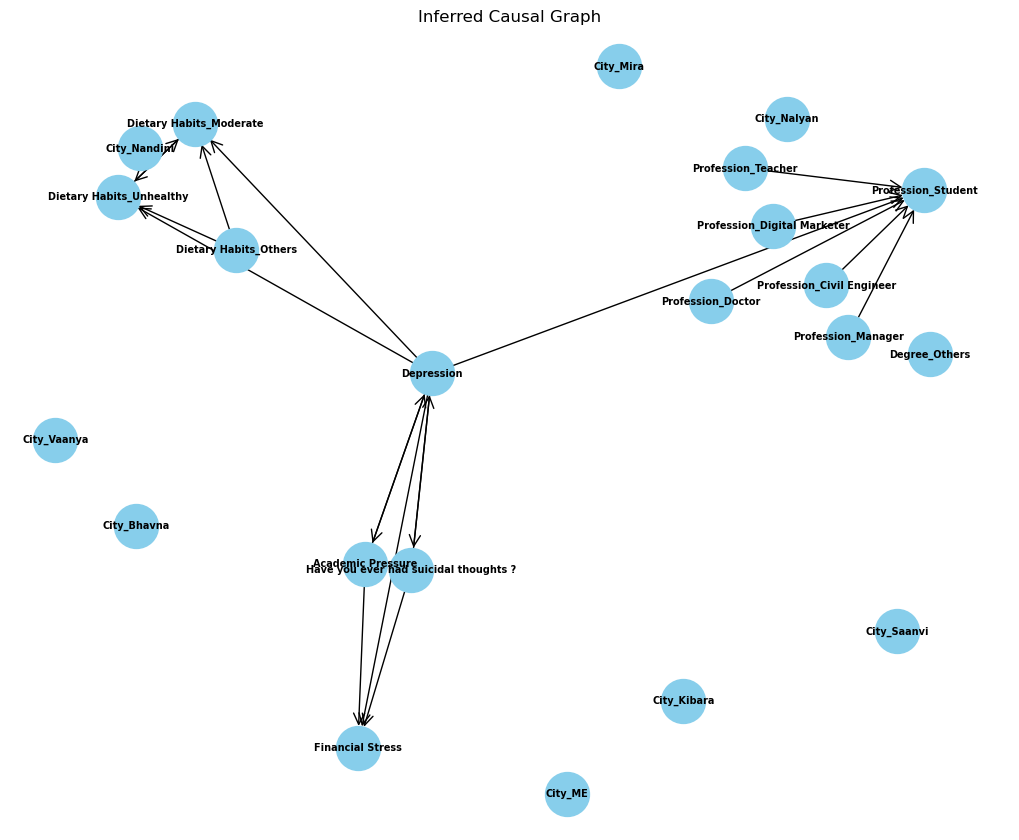

In [34]:
assert pc_graph.G.is_undirected_from_to(nodes[17], nodes[19])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Increase k for more space between nodes
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=1000, node_color="skyblue", font_size=7, font_weight="bold", arrowstyle="->", arrowsize=20)
plt.title("Inferred Causal Graph")
plt.show()

In [37]:
print(nodes[0])

X1
